####  **Import Required Libraries**

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error, r2_score

import joblib

####  **Load Prepared Data**

In [91]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

#### **Feature Engineering**

In [92]:
# Create new binary feature: 1 = active, 0 = non-active
df["status_active"] = df["status"].apply(lambda x: 1 if x == 1 else 0)

In [93]:
df.head()

,call_failure,complains,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn,status_active
0,8,0,0,4370,5,17,3,1,1,197.640,0,1
1,0,0,0,318,7,4,2,1,2,46.035,0,0
2,10,0,0,2453,359,24,3,1,1,1536.520,0,1
3,10,0,0,4198,1,35,1,1,1,240.020,0,1
4,3,0,0,2393,2,33,1,1,1,145.805,0,1


In [94]:
X = df.drop(columns=["customer_value", "churn", "status"])
y = df["customer_value"]

#### **Numeric and Categorical features**

In [95]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "status_active"
]
categorical_features = [ "tariff_plan", "age_group"]

####  **Apply log1p transformation to Target**

In [96]:
y_log = np.log1p(y)  # For regression model training

#### **Split Training and Test Data**

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

#### **Scale Numerical features**

In [98]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

#### **One-hot encode categorical features**

In [99]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

#### **Concatenate scaled numeric + encoded categorical**

In [100]:
X_train_combined = np.hstack([X_train_num, X_train_cat])
X_test_combined = np.hstack([X_test_num, X_test_cat])

#### **Model Training**

In [101]:
lr = LinearRegression()
lr.fit(X_train_combined, y_train)

LinearRegression()

#### **Model Prediction with Test Dataset**

In [102]:
y_pred_linear = lr.predict(X_test_combined)

#### **Evaluate the Model**

In [103]:
# Evaluation
def evaluate_model(name, y_true, y_pred, n_features):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate adjusted R2
    n = len(y_true)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    
    print(f"{name} - RMSE: {rmse:.2f}, R2 Score: {r2:.3f}, Adjusted R2: {adj_r2:.3f}")

##### RMSE and R-Square

In [104]:
evaluate_model("Linear Regression", y_test, y_pred_linear, 9)

Linear Regression - RMSE: 0.41, R2 Score: 0.873, Adjusted R2: 0.871


##### Residuals vs Fitted

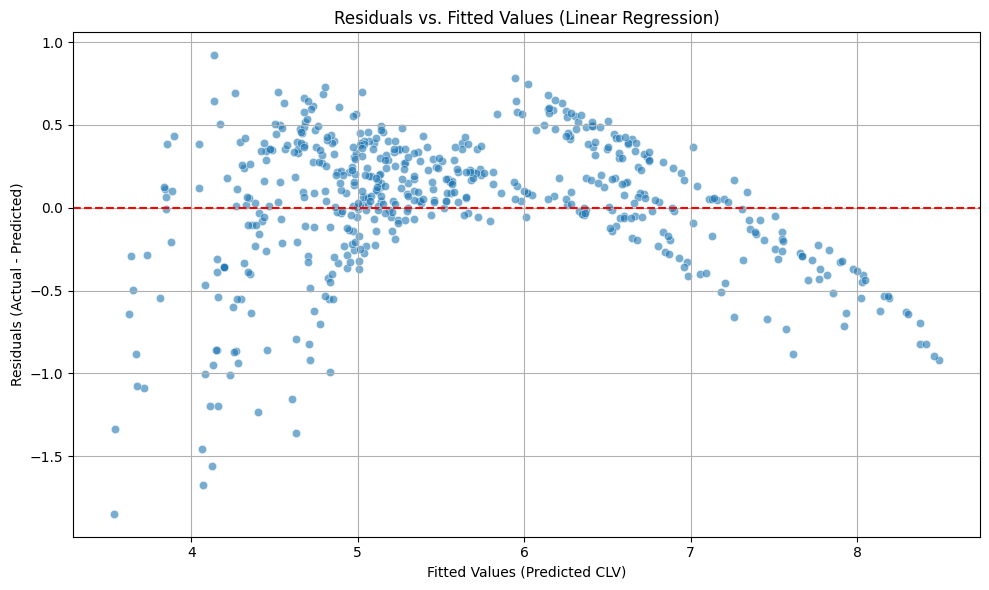

In [105]:
residuals = y_test - y_pred_linear
# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_linear, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Linear Regression)")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


- Strong **non-linear** pattern with downward curve at higher fitted values
- **Heteroscedasticity** - larger variance at fitted values 4-5, smaller at 7-8
- **Outliers** beyond -1.5 in lower fitted values


#### **Polynomial features to handle Non-linearity**

In [106]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(X_test_combined)

In [107]:
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)

#### **Initial Model (One-time Train/Test Split)**

##### **Evaluate the Model with polynomial features**

##### RMSE and R-Square

In [108]:
evaluate_model("Linear Regression - Poly", y_test, y_pred_poly, 9)

Linear Regression - Poly - RMSE: 0.19, R2 Score: 0.972, Adjusted R2: 0.971


##### Residuals vs Fitted

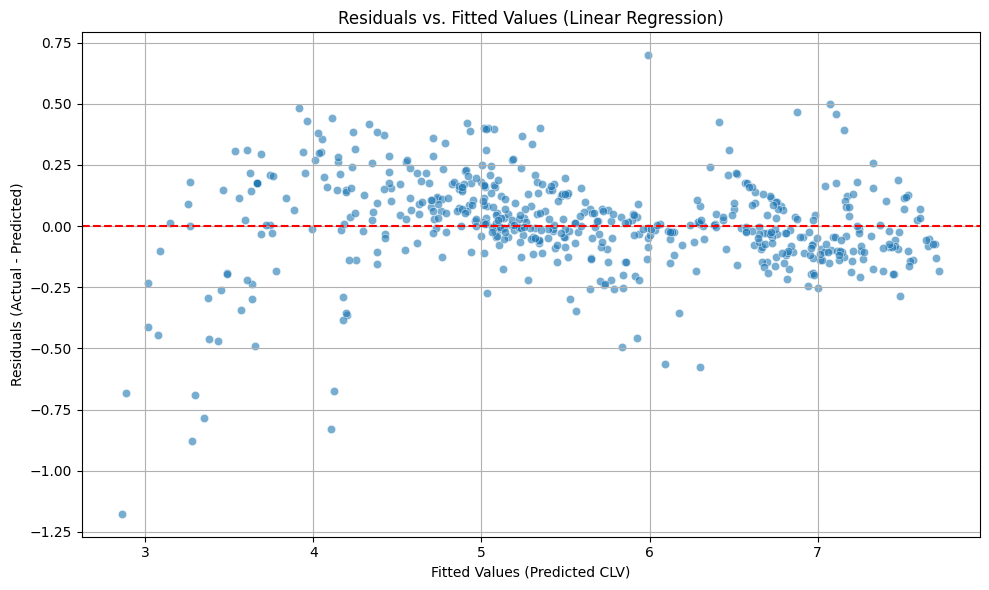

In [109]:
residuals = y_test - y_pred_poly
# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_poly, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Linear Regression)")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


- Much better linear fit - residuals more randomly scattered around zero
- Reduced residual range (mostly between -0.5 to 0.5)
- More consistent variance across fitted values
- Few remaining outliers at lower fitted values, but less extreme

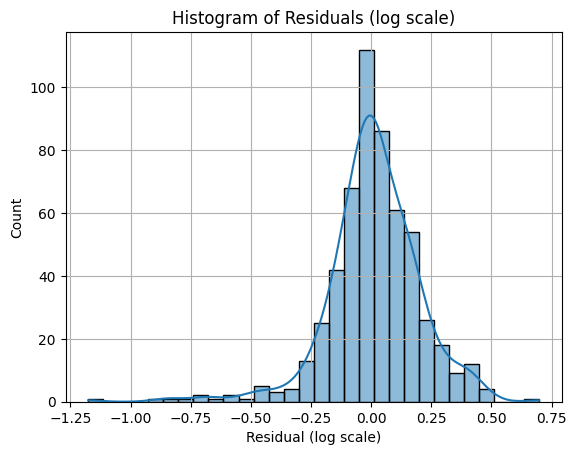

In [110]:
# Histogram (log residuals)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()


**Histogram of Residuals**
- The distribution is roughly bell-shaped and centered around 0, indicating the model is generally unbiased
- Slight left skew and mild tailing suggest a few extreme underpredictions, but not severe.

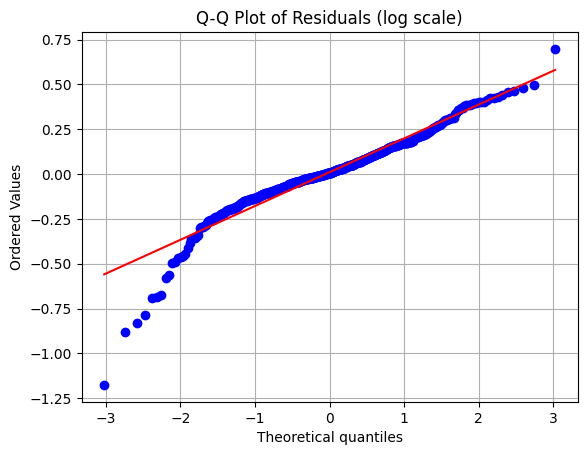

In [111]:
# Q-Q plot (log residuals)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (log scale)")
plt.grid(True)
plt.show()

**Q-Q Plot**
- Residuals closely follow the theoretical normal line in the middle range.
- Deviations at the tails suggest some non-normality in extreme values, especially lower residuals.

#### Evaluation in Real-World Scale (Back-Transformed Predictions)

In [112]:
y_test_actual = np.expm1(y_test)
y_pred_poly_lr_actual = np.expm1(y_pred_poly)

# Evaluate again in real-world terms
evaluate_model("Linear Regression - Poly(Real world)", y_test_actual, y_pred_poly_lr_actual, 9)

Linear Regression - Poly(Real world) - RMSE: 104.31, R2 Score: 0.958, Adjusted R2: 0.958


- R² = 0.958 (95.8% variance explained)
- RMSE of 104.31 indicates average prediction error in actual price units

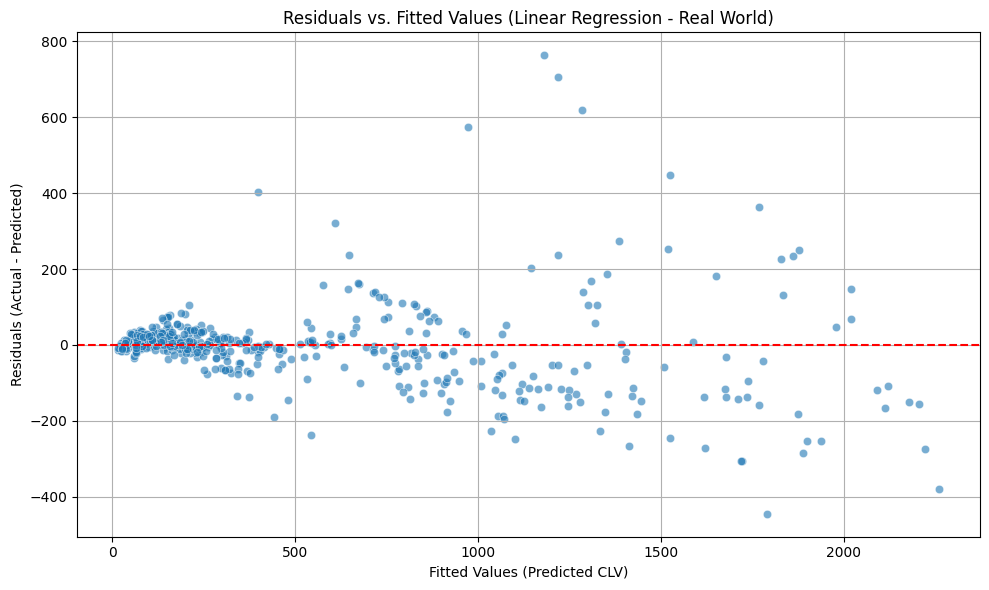

In [113]:
residuals = y_test_actual - y_pred_poly_lr_actual

# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_poly_lr_actual, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Linear Regression - Real World)")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

- **Residual plot analysis:**  
  - For CLV values up to 500, residuals are tightly clustered around zero, meaning the model predicts well for most customers.  
  - For higher CLV values, the spread increases, but most residuals remain within ±200, which is still reasonable.  
  - Only a few extreme outliers exist, primarily at higher CLV values, suggesting some high-value customers may have unique characteristics that the model struggles to capture. 

##### Scatter Plot: Actual vs. Predicted CLV

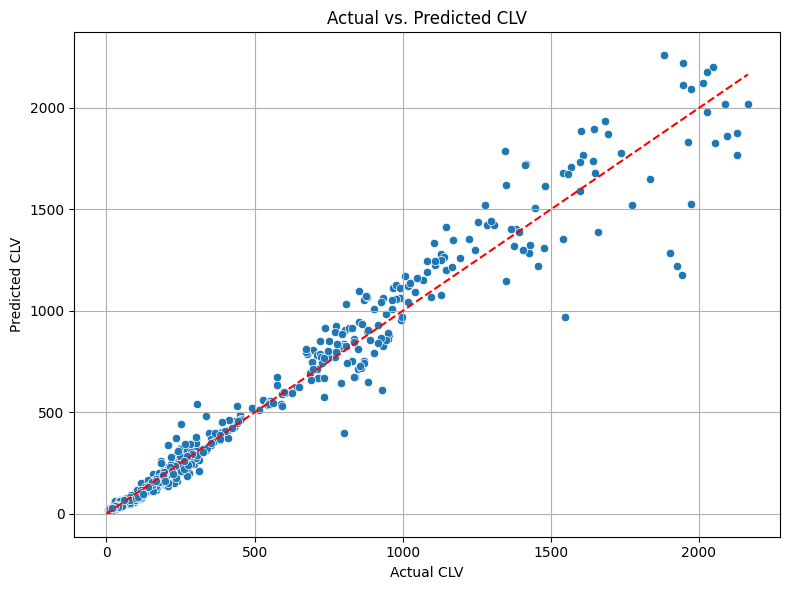

In [114]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_poly_lr_actual)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

This Actual vs. Predicted CLV plot analysis:
- The points align well along the **45-degree red dashed line**, meaning predicted CLV values closely match actual values.  
- Up to ~1000 CLV, predictions are tightly aligned, confirming model reliability for typical customers.  
- Some deviations appear in higher CLV ranges (>1500), with slight underprediction and overprediction.  
- The deviations are not consistently above or below the line, indicating no major skew in predictions.  

#### **Conclusion**

- High R² (0.958) confirms that the model explains nearly all variance in the data.
- Polynomial features effectively capture non-linearity**, improving predictions.  
- Some residual variance remains at high CLV, but overall, the model performs well across the range.

#### **Model Persistence and Predictions Generation**

In [115]:
# Save model and preprocessing objects
joblib.dump(poly_lr, "../resources/models/poly_lr_model.pkl")
joblib.dump(scaler, "../resources/models/scaler.pkl")
joblib.dump(encoder, "../resources/models/encoder.pkl")
joblib.dump(poly, "../resources/models/poly_features.pkl")

# Preprocess
X_num = scaler.transform(df[numeric_features])
X_cat = encoder.transform(df[categorical_features])
X_combined = np.hstack([X_num, X_cat])

# Apply polynomial transformation
X_poly = poly.transform(X_combined)

# Predict log1p(customer_value)
log_clv_pred = poly_lr.predict(X_poly)

df.drop(columns=["status_active"], inplace=True)
# Convert to real CLV
df["predicted_clv"] = np.expm1(log_clv_pred)

# Save updated dataset
df.to_csv("../resources/data/output/customer_churn_with_predicted_clv.csv", index=False)

#### **Cross Validation**

In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np


# Column transformer
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), categorical_features)
])

# Pipeline: preprocess → polynomial → linear regression
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

# Cross-validation
neg_rmse_scores = cross_val_score(full_pipeline, X, y, scoring='neg_root_mean_squared_error', cv=5)
r2_scores = cross_val_score(full_pipeline, X, y, scoring='r2', cv=5)

print(f"Cross-validated RMSE scores: {-neg_rmse_scores}")
print(f"Average RMSE: {-neg_rmse_scores.mean():.2f}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average R2: {r2_scores.mean():.2f}")


Cross-validated RMSE scores: [0.36463727 5.66870611 0.4326677  0.34518297 0.44132296]
Average RMSE: 1.45
Cross-validated R2 scores: [0.99999952 0.99987985 0.99999933 0.99999953 0.99999921]
Average R2: 1.00
